In [3]:
!pip install quantecon

     |████████████████████████████████| 214 kB 2.1 MB/s eta 0:00:01


In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import quantecon as qe
from numba import njit, prange
from quantecon.distributions import BetaBinomial
from scipy.special import binom, beta
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


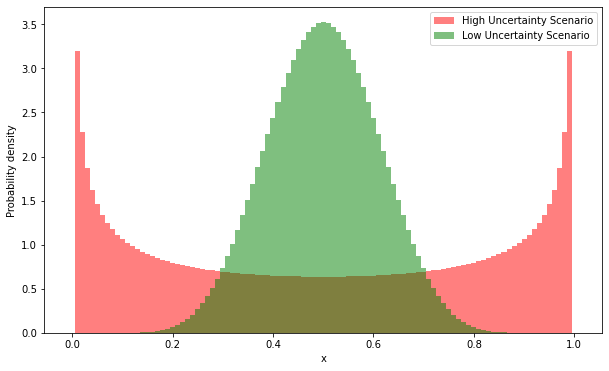

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def gen_probs(n, a, b):
    x = np.linspace(0, 1, n+1)
    probs = beta.pdf(x, a, b)
    return x, probs

n = 100  # Use a finer resolution for smoother curves
a_vals = [0.5, 10]
b_vals = [0.5, 10]
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red', 'green']  # Define colors for each scenario
labels = ['High Uncertainty Scenario', 'Low Uncertainty Scenario']  # Labels for each scenario

for (a, b), color, label in zip(zip(a_vals, b_vals), colors, labels):
    x, probs = gen_probs(n, a, b)
    # Use label for scenario description instead of a and b values
    ax.bar(x, probs, width=x[1]-x[0], label=label, color=color, alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('Probability density')
ax.legend()
plt.show()


In [5]:
class CareerWorkerProblem_beforechipwar:
    def __init__(self,
                 B=5.0,          # Upper bound
                 β=0.95,         # Discount factor
                 grid_size=50,   # Grid size
                 F_a=10,
                 F_b=10,
                 G_a=10,
                 G_b=10):
        self.β, self.grid_size, self.B = β, grid_size, B

        self.θ = np.linspace(0, B, grid_size)     # Set of θ values
        self.ϵ = np.linspace(0, B, grid_size)     # Set of ϵ values

        self.F_probs = BetaBinomial(grid_size - 1, F_a, F_b).pdf()
        self.G_probs = BetaBinomial(grid_size - 1, G_a, G_b).pdf()
        self.F_mean = np.sum(self.θ * self.F_probs)
        self.G_mean = np.sum(self.ϵ * self.G_probs)

        # Store these parameters for str and repr methods
        self._F_a, self._F_b = F_a, F_b
        self._G_a, self._G_b = G_a, G_b

In [6]:
class CareerWorkerProblem_afterchipwar:

    def __init__(self,
                 B=5.0,          # Upper bound
                 β=0.95,         # Discount factor
                 grid_size=50,   # Grid size
                 F_a=0.5,
                 F_b=0.5,
                 G_a=0.5,
                 G_b=0.5):

        self.β, self.grid_size, self.B = β, grid_size, B

        self.θ = np.linspace(0, B, grid_size)     # Set of θ values
        self.ϵ = np.linspace(0, B, grid_size)     # Set of ϵ values

        self.F_probs = BetaBinomial(grid_size - 1, F_a, F_b).pdf()
        self.G_probs = BetaBinomial(grid_size - 1, G_a, G_b).pdf()
        self.F_mean = np.sum(self.θ * self.F_probs)
        self.G_mean = np.sum(self.ϵ * self.G_probs)

        # Store these parameters for str and repr methods
        self._F_a, self._F_b = F_a, F_b
        self._G_a, self._G_b = G_a, G_b

In [7]:
def operator_factory(cw, parallel_flag=True):

    """
    Returns jitted versions of the Bellman operator and the
    greedy policy function

    cw is an instance of ``CareerWorkerProblem``
    """

    θ, ϵ, β = cw.θ, cw.ϵ, cw.β
    F_probs, G_probs = cw.F_probs, cw.G_probs
    F_mean, G_mean = cw.F_mean, cw.G_mean

    @njit(parallel=parallel_flag)
    def T(v):
        "The Bellman operator"

        v_new = np.empty_like(v)

        for i in prange(len(v)):
            for j in prange(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]                    # Stay put
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs        # New job
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs  # New life
                v_new[i, j] = max(v1, v2, v3)

        return v_new

    @njit
    def get_greedy(v):
        "Computes the v-greedy policy"

        σ = np.empty(v.shape)

        for i in range(len(v)):
            for j in range(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs
                if v1 > max(v2, v3):
                    action = 1
                elif v2 > max(v1, v3):
                    action = 2
                else:
                    action = 3
                σ[i, j] = action

        return σ

    return T, get_greedy

In [8]:
def solve_model(cw,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    T, _ = operator_factory(cw, parallel_flag=use_parallel)

    # Set up loop
    v = np.full((cw.grid_size, cw.grid_size), 100.)  # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if error > tol:
        print("Failed to converge!")

    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_new

Plot saved to Normal.png


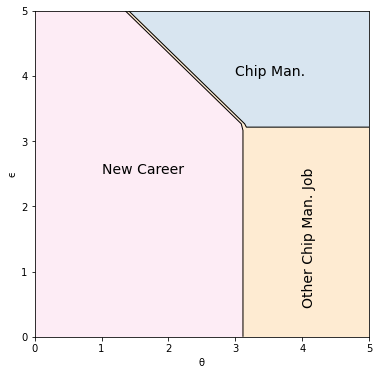

In [17]:
cw = CareerWorkerProblem_beforechipwar()
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
lvls = (0.5, 1.5, 2.5, 3.5)
ax.contourf(tg, eg, greedy_star.T, levels=lvls, cmap=cm.Pastel1, alpha=0.5)
ax.contour(tg, eg, greedy_star.T, colors='k', levels=lvls, linewidths=1)
ax.set(xlabel='θ', ylabel='ϵ')
ax.text(1, 2.5, 'New Career', fontsize=14)
ax.text(4, 0.5, 'Other Chip Man. Job', fontsize=14, rotation='vertical')
ax.text(3, 4, 'Chip Man.', fontsize=14)
#plt.show()


# Specify the filename and path where the plot will be saved
filename = "Normal.png"
# Save the figure to a PNG file. You can adjust the dpi for higher resolution.
plt.savefig(filename, dpi=300)
# Print a message to confirm the plot has been saved
print(f"Plot saved to {filename}")

Plot saved to HighUncertainty.png


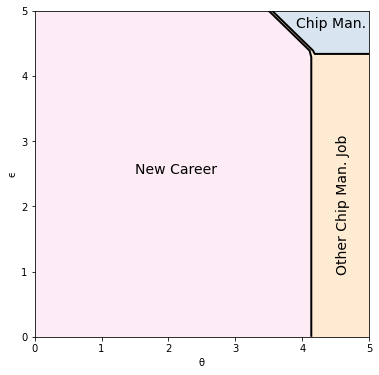

In [19]:
cw = CareerWorkerProblem_afterchipwar()
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
lvls = (0.5, 1.5, 2.5, 3.5)
ax.contourf(tg, eg, greedy_star.T, levels=lvls, cmap=cm.Pastel1, alpha=0.5)
ax.contour(tg, eg, greedy_star.T, colors='k', levels=lvls, linewidths=2)
ax.set(xlabel='θ', ylabel='ϵ')
ax.text(1.5, 2.5, 'New Career', fontsize=14)
ax.text(4.5, 1, 'Other Chip Man. Job', fontsize=14, rotation='vertical')
ax.text(3.9, 4.75, 'Chip Man.', fontsize=14)
#plt.show()


# Specify the filename and path where the plot will be saved
filename = "HighUncertainty.png"
# Save the figure to a PNG file. You can adjust the dpi for higher resolution.
plt.savefig(filename, dpi=300)
# Print a message to confirm the plot has been saved
print(f"Plot saved to {filename}")

